In [1]:
#yahoo finance as data source
#pip install yfinance
import yfinance as yf

In [2]:
#See the yahoo finance ticker for your stock symbol
stock_symbol = 'GAIL.NS'


In [3]:
#last 5 years data with interval of 1 day
data = yf.download(tickers=stock_symbol,period='5y',interval='1d')

[*********************100%***********************]  1 of 1 completed


In [4]:
type(data)

pandas.core.frame.DataFrame

In [5]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-04-18,109.133331,110.849998,108.666664,110.216667,87.610435,6423006
2018-04-19,110.733330,112.666664,109.483330,111.783333,88.855766,7985997
2018-04-20,112.583336,114.250000,108.349998,110.183334,87.583946,11878695
2018-04-23,110.900002,111.800003,109.199997,110.849998,88.113876,7651770
2018-04-24,111.333336,113.266663,110.283333,112.583336,89.491692,5144688


In [6]:
len(data)

1235

In [7]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-04-11,106.000000,107.099998,105.550003,106.050003,106.050003,8331690
2023-04-12,106.050003,108.849998,105.800003,108.599998,108.599998,14151790
2023-04-13,111.000000,111.000000,107.099998,108.150002,108.150002,15062407
2023-04-17,108.150002,110.599998,107.550003,110.099998,110.099998,11580594
2023-04-18,109.300003,110.599998,109.050003,109.500000,109.500000,9664860


In [8]:
opn = data[['Open']]

<Axes: xlabel='Date'>

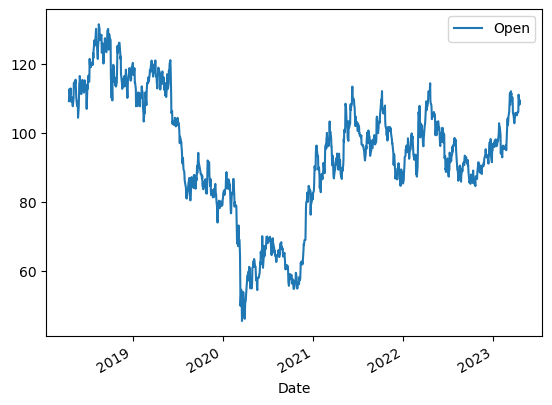

In [9]:
opn.plot()

In [10]:
import matplotlib.pyplot as plt

In [11]:
ds = opn.values

In [12]:
ds

array([[109.1333313 ],
       [110.73332977],
       [112.58333588],
       ...,
       [111.        ],
       [108.15000153],
       [109.30000305]])

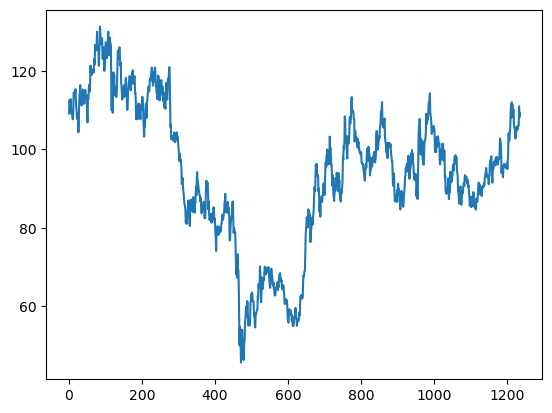

In [13]:
plt.plot(ds)

In [14]:
import numpy as np

In [15]:

from sklearn.preprocessing import MinMaxScaler

In [16]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [17]:
len(ds_scaled), len(ds)

(1235, 1235)

In [18]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [19]:
train_size,test_size

(864, 371)

In [20]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [21]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [22]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [23]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [24]:
X_train.shape,y_train.shape

((763, 100), (763,))

In [25]:

X_test.shape, y_test.shape

((270, 100), (270,))

In [26]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [27]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [28]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [29]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
12/12 [==============================] - 8s 229ms/step - loss: 0.0922 - val_loss: 0.0076
Epoch 2/100
12/12 [==============================] - 2s 127ms/step - loss: 0.0156 - val_loss: 0.0094
Epoch 3/100
12/12 [==============================] - 1s 118ms/step - loss: 0.0096 - val_loss: 0.0039
Epoch 4/100
12/12 [==============================] - 1s 116ms/step - loss: 0.0058 - val_loss: 0.0031
Epoch 5/100
12/12 [==============================] - 1s 117ms/step - loss: 0.0047 - val_loss: 0.0024
Epoch 6/100
12/12 [==============================] - 1s 120ms/step - loss: 0.0044 - val_loss: 0.0024
Epoch 7/100
12/12 [==============================] - 1s 115ms/step - loss: 0.0043 - val_loss: 0.0025
Epoch 8/100
12/12 [==============================] - 1s 115ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 9/100
12/12 [==============================] - 1s 116ms/step - loss: 0.0040 - val_loss: 0.0023
Epoch 10/100
12/12 [==============================] - 1s 117ms/step - loss: 0.0038 - val_lo

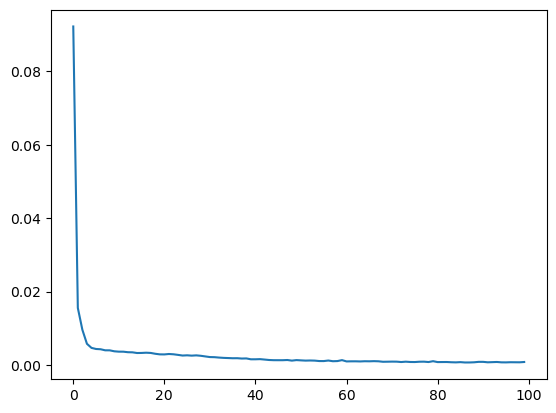

In [30]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [31]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9/9 [==============================] - 0s 26ms/step


In [32]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

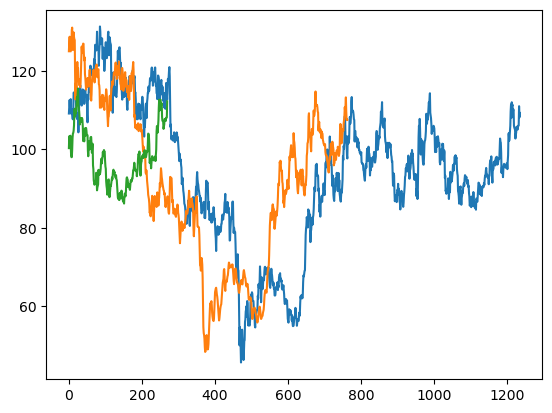

In [33]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [34]:
type(train_predict)

numpy.ndarray

In [35]:
test = np.vstack((train_predict,test_predict))

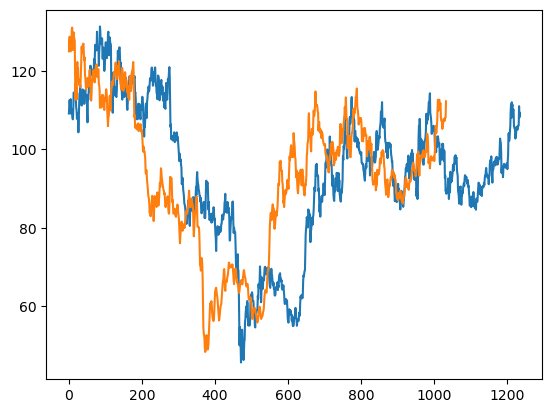

In [36]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [37]:
len(ds_test)

371

In [38]:
#Getting the last 100 days records
fut_inp = ds_test[270:]

In [39]:
fut_inp = fut_inp.reshape(1,-1)

In [40]:
tmp_inp = list(fut_inp)

In [41]:
fut_inp.shape

(1, 101)

In [42]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [43]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.7613411545753479], [0.7796496748924255], [0.7978625297546387], [0.8147706985473633], [0.8303204774856567], [0.8445203900337219], [0.8575177192687988], [0.8694992661476135], [0.8806271553039551], [0.8910208940505981], [0.9007635712623596], [0.9099153876304626], [0.918527364730835], [0.9266491532325745], [0.9343326091766357], [0.9416298270225525], [0.9485892653465271], [0.9552545547485352], [0.9616620540618896], [0.967839241027832], [0.9738061428070068], [0.9795751571655273], [0.9851535558700562], [0.990544319152832], [0.9957482814788818], [1.0007635354995728], [1.0055888891220093], [1.0102227926254272], [1.0146641731262207], [1.0189130306243896]]


In [44]:
len(ds_scaled)

1235

In [45]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

In [ ]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[1132:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [47]:
ds_new = ds_scaled.tolist()

In [48]:
len(ds_new)

1235

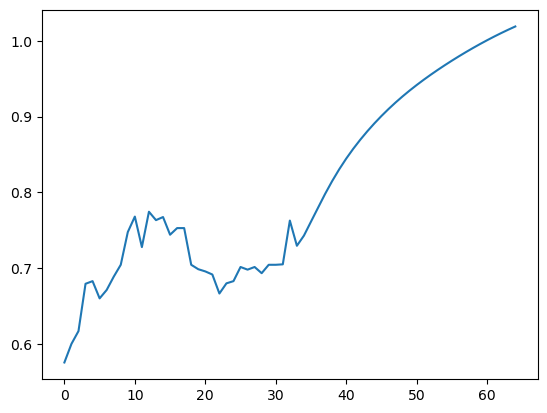

In [49]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [52]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

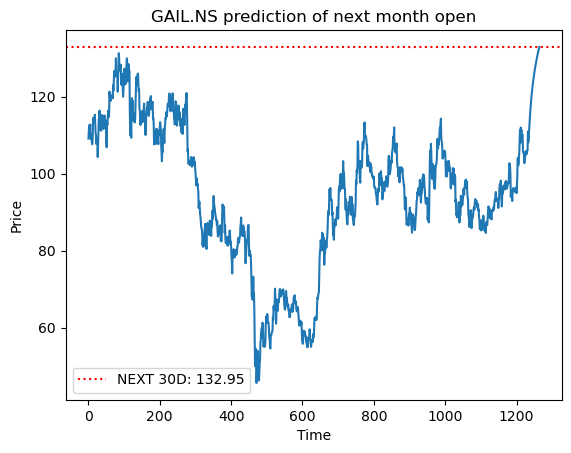

In [53]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()